In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import json
FILE_PATH_DICT = "case_id_and_structure.json"
with open(FILE_PATH_DICT, 'r') as file:
    file_parsed = json.load(file)

methylation_folder_list = []
for key in file_parsed.keys():
    methylation_folder_list.append(file_parsed[key]["files"]["methylation"])

        

In [4]:
import os
PATH_METHYLATION = "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/Methylation"
number_of_rows = []
for root, dirs, files in os.walk(PATH_METHYLATION):
    for dir in dirs:
        for root, dirs, files in os.walk(PATH_METHYLATION + "/" + dir):
            for file in files:
                if file in methylation_folder_list:
                    with open(PATH_METHYLATION + "/" + dir + "/" + file, 'r') as fp:
                        lines = len(fp.readlines())
                        print('Total Number of lines:', lines)
                        number_of_rows.append(int(lines))

methylation = pd.Series(number_of_rows)


Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number of lines: 27578
Total Number o

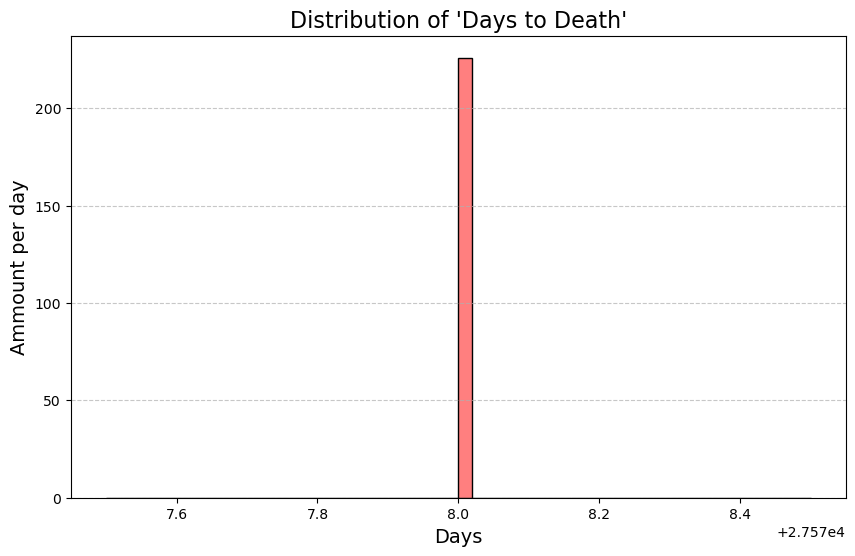

In [5]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(methylation, bins=50, kde=True, color="red")
plt.title("Distribution of \'Days to Death\'", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Ammount per day", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
print(methylation.max())
print(methylation.min())

27578
27578


In [7]:
# Lista che conterrà le posizioni dei NaN per ogni file
list_of_NaN = {}
count = 0
count_record = 0
# Cammina nella directory
for root, dirs, files in os.walk(PATH_METHYLATION):
    for file in files:
        # Controlla se il file è nella lista specificata
        if file in methylation_folder_list:
            file_path = os.path.join(root, file)
            # Apri il file e leggi riga per riga
            with open(file_path, 'r') as fp:
                lines = fp.readlines()
            # Cerca "NA" in ogni riga e salva la posizione
            nan_positions = []
            for i, line in enumerate(lines):
                count_record = count_record +1
                if "NA" in line:  # Verifica se "NA" è presente nella riga
                    nan_positions.append(i)
                    count = count +1
            # Aggiungi alla lista di liste
            list_of_NaN[file] = nan_positions

# Trasforma la lista in una serie di pandas per un'analisi più semplice
methylation = pd.Series(list_of_NaN)

# Stampa i risultati
print(methylation)
print(len(list_of_NaN))
print(count)
print(count_record)
print(count/count_record)



c3f5ce9a-9138-4ef2-ae07-3c6985595aa9.methylation_array.sesame.level3betas.txt    [9, 22, 46, 54, 55, 58, 60, 69, 83, 88, 102, 1...
8d2a609e-c2c3-4519-ae30-c7b6330c2c71.methylation_array.sesame.level3betas.txt    [9, 22, 46, 54, 55, 58, 60, 69, 83, 88, 102, 1...
d4292db8-ecae-4127-9989-0e7e9ee9d3ec.methylation_array.sesame.level3betas.txt    [9, 22, 39, 46, 50, 54, 55, 58, 60, 69, 83, 88...
287e60d5-8f5d-4604-98ac-f771fca970fb.methylation_array.sesame.level3betas.txt    [9, 22, 46, 54, 55, 58, 60, 69, 83, 88, 102, 1...
e0b5c688-22c0-4c9a-b52d-9e9394449886.methylation_array.sesame.level3betas.txt    [9, 22, 46, 50, 54, 55, 58, 60, 69, 83, 88, 10...
                                                                                                       ...                        
49b80937-9772-45fe-89b9-c46d0eabbe94.methylation_array.sesame.level3betas.txt    [9, 22, 46, 50, 54, 55, 58, 60, 69, 83, 88, 10...
9855b9f1-6c59-4fe1-ba86-8fd94a95f63c.methylation_array.sesame.level3betas.txt    [9

In [8]:
for idx, file in enumerate(list_of_NaN):
    count_na = len(file)
    print(f"Riga {idx + 1}: {count_na} valori NA")

Riga 1: 77 valori NA
Riga 2: 77 valori NA
Riga 3: 77 valori NA
Riga 4: 77 valori NA
Riga 5: 77 valori NA
Riga 6: 77 valori NA
Riga 7: 77 valori NA
Riga 8: 77 valori NA
Riga 9: 77 valori NA
Riga 10: 77 valori NA
Riga 11: 77 valori NA
Riga 12: 77 valori NA
Riga 13: 77 valori NA
Riga 14: 77 valori NA
Riga 15: 77 valori NA
Riga 16: 77 valori NA
Riga 17: 77 valori NA
Riga 18: 77 valori NA
Riga 19: 77 valori NA
Riga 20: 77 valori NA
Riga 21: 77 valori NA
Riga 22: 77 valori NA
Riga 23: 77 valori NA
Riga 24: 77 valori NA
Riga 25: 77 valori NA
Riga 26: 77 valori NA
Riga 27: 77 valori NA
Riga 28: 77 valori NA
Riga 29: 77 valori NA
Riga 30: 77 valori NA
Riga 31: 77 valori NA
Riga 32: 77 valori NA
Riga 33: 77 valori NA
Riga 34: 77 valori NA
Riga 35: 77 valori NA
Riga 36: 77 valori NA
Riga 37: 77 valori NA
Riga 38: 77 valori NA
Riga 39: 77 valori NA
Riga 40: 77 valori NA
Riga 41: 77 valori NA
Riga 42: 77 valori NA
Riga 43: 77 valori NA
Riga 44: 77 valori NA
Riga 45: 77 valori NA
Riga 46: 77 valori 

In [9]:
#parte che va a sostituire tutti i NaN con 0

In [10]:
#parte che va a eliminare le righe

In [11]:
PATH_METHYLATION + "/" + dir + "/" + file

'/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/Methylation/logs/55904868-b373-4449-ac92-ce77820c4e37.methylation_array.sesame.level3betas.txt'